In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../src/')
import wave_mut_rate as wD
import utils as ut
import plotter
import pickle
from copy import deepcopy
from scipy.optimize import brentq

In [2]:
class eps_schedule():
    """
    Scheduling of the diffusion coefficient over the mutation rate
    """
    
    def __init__(self, first_eps, first_time, decay_exp, decay_scale):
        self.first_eps = first_eps
        self.first_time = first_time
        self.decay_exp = decay_exp
        self.decay_scale = decay_scale
        
    def get(self, t):
        if t < self.first_time:
            return self.first_eps
        else:
            t1 = t - self.first_time
            return self.first_eps*( self.decay_scale/(t1 + self.decay_scale) )**self.decay_exp


In [3]:
def build_assay_wave(id_, r0, lambda_tilde, Ds, D_CLF, beta, gamma,  eps=1e-13, time=3000, dx=1):
    
    dx_aux = ut.lin_from_two_log_points(r0/Delta_x, 0.5, 0.06, 50, 0.2)
    dt = ut.dt_from_cfl(0.03, D_CLF, dx_aux)
    dx = Delta_x
    
    p = wD.Vwave_mut_rate_pars(id_, tot_time=time, dt=dt, dx=dx, 
                     n_x_bins=int( ut.lin_from_two_points(r0/Delta_x, 0.25, 100, 50, 4000)/dx ), 
                     M=5, r0=r0, alpha=0, beta=beta, gamma=gamma, lambda_tilde=lambda_tilde,
                     eps=eps, Ds=Ds,
                     Nh=10**10, N0=10**8, cutoff=1,
                     t_burn=ut.lin_from_two_points(r0/Delta_x, 0.05, 250, 5, 20000), 
                     t_burn_cutoff=ut.lin_from_two_points(r0/Delta_x, 0.05, 70, 5, 5000), 
                     #t_burn=200, t_burn_cutoff=100,
                     back_width_fract=ut.lin_from_two_log_points(r0/Delta_x, 0.5, 0.5, 50, 3),
                     traj_step=int(25/dt), check_step=int(0/dt), traj_after_burn=True, verbose=True, 
                     global_cutoff=True)
    
    return deepcopy(wD.Vwave_mut_rate(p, False))

In [4]:
def D_FKPP_f(p):
    return (p.beta - p.alpha - p.gamma)/(2*p.beta*p.lambda_tilde)
    
    
def vtau_lin(p, meanD):
    return p.r0*((p.beta*(1 - p.lambda_tilde*meanD)/(p.alpha + p.gamma))**(1/p.M) - 1)**(-1)

def sel_coef_lin(p, meanD):
    return (p.alpha + p.gamma)*p.M/vtau_lin(p, meanD)

def speed_lin(p, size, meanD):
    s = sel_coef_lin(p, meanD)
    d_inv = (s/meanD)**(1/3)
    eps0 = - 2.3381
    aux = 3*np.log(size*d_inv)
    return 2*meanD*d_inv*(aux**(1/3) + eps0*aux**(-1/3))

def size_lin(p, meanD):
    vtau = vtau_lin(p, meanD)
    def _Neq(x, p, vtau):
        return (vtau - speed_lin(p, x, meanD)*p.M*p.Nh/x)
    return brentq(_Neq, 1e4, p.Nh*1000, args = (p, vtau))

def D_f_lin(p, D_left, D_right):
    xi0 = - 2.3381
    def f(x):
        Ntot = size_lin(p, x)
        v = speed_lin(p, Ntot, x)
        s = sel_coef_lin(p, x)
        k = xi0 * (x*s**2)**(1/3)
        f = v**2/4/x - k
        return f*(1 - 2*p.lambda_tilde*x) + 2*k*(2/3 - p.lambda_tilde*x) - (p.alpha + p.gamma)*p.lambda_tilde*x
    return brentq(f, D_left, D_right)

def estf(d):
    k = -2.3381 * (d*s**2)**(1/3)
    return f*(1 - 2*l*d) + 2*k*(2/3 - l*d) - (a+g)*l*d

In [48]:
assay = assays[7]
assay.run()
print(assay.p.r0, assay.p.r0**2*(beta - gamma)/assay.traj.mean_D[-1])

Process 7:   0%|          | 0/47791 [00:00<?, ?it/s]

3.8729833462074175 552.8761028465916


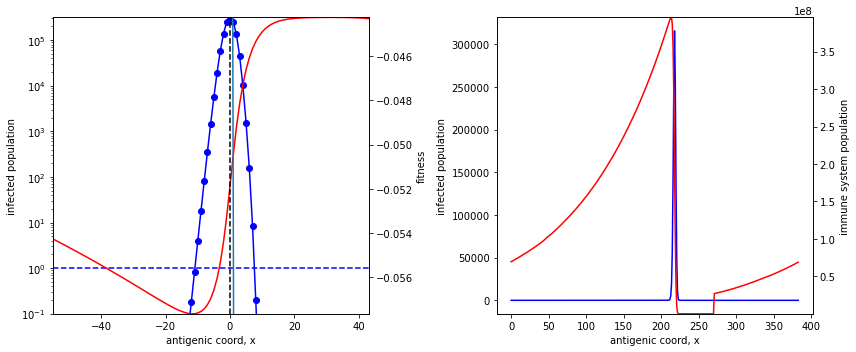

In [49]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
plotter.plot_fitness(ax1, assay)
plotter.plot_populations(ax2, assay)
plt.tight_layout()

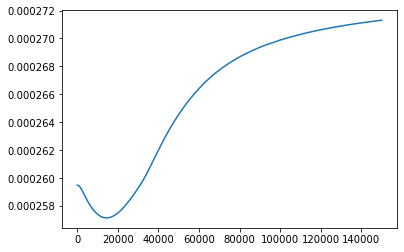

In [50]:
plt.plot(assay.traj.times - assay.p.t_burn, assay.traj.mean_D)

## Finding ES mutation coef for different r0

In [5]:
Delta_x = 1
beta = 0.05
gamma = 0.04
lambd = 100
c_list = np.logspace(np.log10(0.5), np.log10(30), 15)
r0_list = c_list * Delta_x
lambda_tilde = 2*lambd/Delta_x**2
print(c_list)

[ 0.5         0.66985501  0.89741146  1.20227112  1.61069466  2.15786376
  2.89091169  3.87298335  5.18867457  6.95131928  9.31275205 12.47638718
 16.71474085 22.39290569 30.        ]


### We set a naive guess of the ED diffusion coefficient and the domain of D in which it is contained

In [6]:
i_change = int(len(c_list)*0.55)
D_guess1 = [ut.lin_from_two_log_points(c, 0.5, 3.3e-4, 5, 2.5e-4) for c in c_list[:i_change]]
D_guess2 = [ut.lin_from_two_log_points(c, 5, 2.5e-4, 50, 0.5e-4) for c in c_list[i_change:]]
D_guess = np.concatenate((D_guess1, D_guess2)) * Delta_x**2
D_window_up = D_guess+1.2e-4 * Delta_x**2
D_window_low = np.max([np.ones(len(r0_list))*1e-6, D_guess-1.2e-4* Delta_x**2], axis=0) 

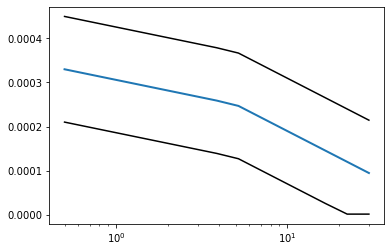

In [7]:
plt.xscale('log')
plt.plot(r0_list, D_guess, lw=2)
plt.plot(r0_list, D_window_low, c='k')
plt.plot(r0_list, D_window_up, c='k')

### Building the ES wave objects

In [8]:
n_D_bins = 200
time = 300000

In [9]:
assays = []
for i, r0 in enumerate(r0_list):
    Ds = np.linspace(D_window_low[i], D_window_up[i], n_D_bins)
    eps = eps_schedule(0.2e-13, 30000, 2, 20000)
    #eps = eps_schedule(0.3e-13, 3000, 2, 500)
    D_CLF = D_guess[i]/2
    assays.append(build_assay_wave(i, r0, lambda_tilde, Ds, D_CLF, beta=beta, gamma=gamma, time=time, eps=eps))

proc. 0 WARNING: dx is not small compared to r0. dx/r0= 2.0
proc. 1 WARNING: dx is not small compared to r0. dx/r0= 1.4928603796564521
proc. 2 WARNING: dx is not small compared to r0. dx/r0= 1.1143160565740031
proc. 3 WARNING: dx is not small compared to r0. dx/r0= 0.8317591456371733
proc. 4 WARNING: dx is not small compared to r0. dx/r0= 0.6208501369693183
proc. 5 WARNING: dx is not small compared to r0. dx/r0= 0.4634212855928884
proc. 6 WARNING: dx is not small compared to r0. dx/r0= 0.3459116381755402
proc. 7 WARNING: dx is not small compared to r0. dx/r0= 0.2581988897471611
proc. 8 WARNING: dx is not small compared to r0. dx/r0= 0.1927274462874107
proc. 9 WARNING: dx is not small compared to r0. dx/r0= 0.14385758431742118
proc. 10 WARNING: dx is not small compared to r0. dx/r0= 0.10737964397028277


### Running simulations
No pickle files are included in the repo since they have large dimensions

In [10]:
waves = ut.multiprocess_sim(assays, 4)

Process 0:   0%|          | 0/461458 [00:00<?, ?it/s]

Process 2:   0%|          | 0/259031 [00:00<?, ?it/s]

Process 1:   0%|          | 0/340019 [00:00<?, ?it/s]

Process 3:   0%|          | 0/202578 [00:00<?, ?it/s]

Process 4:   0%|          | 0/161845 [00:00<?, ?it/s]

Process 5:   0%|          | 0/131640 [00:00<?, ?it/s]

Process 6:   0%|          | 0/108750 [00:00<?, ?it/s]

Process 7:   0%|          | 0/91106 [00:00<?, ?it/s]

Process 8:   0%|          | 0/76728 [00:00<?, ?it/s]

Process 9:   0%|          | 0/61690 [00:00<?, ?it/s]

Process 10:   0%|          | 0/49673 [00:00<?, ?it/s]

Process 11:   0%|          | 0/39941 [00:00<?, ?it/s]

Process 12:   0%|          | 0/31936 [00:00<?, ?it/s]

Process 13:   0%|          | 0/25214 [00:00<?, ?it/s]

Process 14:   0%|          | 0/19400 [00:00<?, ?it/s]

In [11]:
f = open('data/mut_rate_discrete_Dx=%g_assays.pickle'%Delta_x, 'wb')
pickle.dump(waves, f)
f.close()

In [12]:
f = open('data/mut_rate_discrete_Dx=%g_assays.pickle'%Delta_x, 'rb')
waves = pickle.load(f)
f.close()

### Checking convergence to the stationary state

0.5
0.6698550069565965
0.897411460689644
1.2022711204863819
1.6106946595542408
2.1578637647613177
2.89091169431116
3.8729833462074175
5.1886745726331025
6.951319283893326
9.312752054539772
12.476387184557597
16.714740848610045
22.392905694846775
29.999999999999996


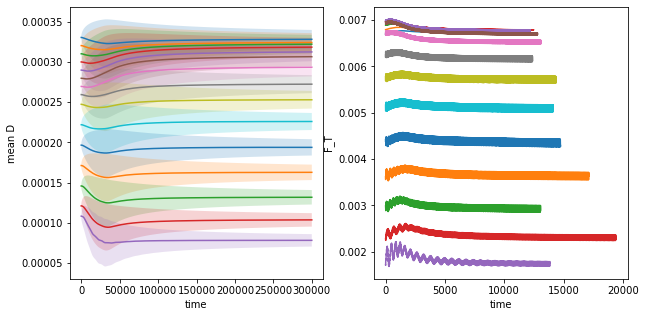

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.set_xlabel('time')
ax1.set_ylabel('mean D')
ax2.set_xlabel('time')
ax2.set_ylabel('F_T')

mean_D, max_D = [], []
speeds, f_tips, s_tips = np.array([]),np.array([]), np.array([])
r0_lin_start = 2
D_flin = np.array([])
est = np.array([])
for w in waves:
    speeds = np.append(speeds, np.mean(w.traj.speed(5)[-50:]))
    f_tips = np.append(f_tips, np.mean(w.traj.f_tip[-50:]))
    s_tips = np.append(s_tips, np.mean(w.traj.s_tip[-50:]))
    mean_D.append(w.traj.mean_D[-1]),
    max_D.append(w.traj.max_D[-1])
    
    ax1.plot(w.traj.times - w.p.t_burn, w.traj.mean_D)
    std = w.traj.std_D
    ax1.fill_between(w.traj.times - w.p.t_burn, w.traj.mean_D-std, w.traj.mean_D+std, alpha=0.2)
    ax2.plot(w.traj.f_tip)
    
    a, g, l = w.p.alpha, w.p.gamma, w.p.lambda_tilde
    v, f, s = speeds[-1], f_tips[-1], s_tips[-1]
    #est = np.append(est, brentq(estf, 1e-4, 6e-4))
    print(w.p.r0)
    #if w.p.r0 > r0_lin_start:
        #D_flin = np.append(D_flin, D_f_lin(w.p, 1e-5, 1.3e-4))

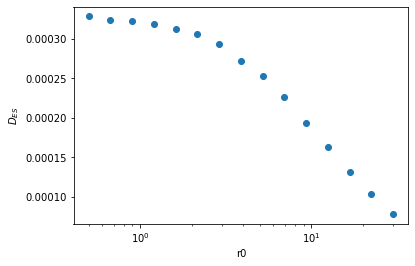

In [15]:
plt.xscale('log')
plt.xlabel('r0')
plt.ylabel(r'$D_{ES}$')
plt.scatter(r0_list, mean_D)
#plt.plot(r0_list, est)

#plt.plot(r0s[r0s > r0_lin_start], D_flin_list, c='k', ls='--', lw=2)

#r0_FKPP_end = 1
#plt.plot(r0s[r0s < r0_FKPP_end], np.ones(len(r0s[r0s < r0_FKPP_end]))*D_FKPP, c='k', ls=':', lw=2)

## Exporing the points

In [22]:
f = open('data/ES_mut_rate_discr.tsv', 'w')

header = '#r0\tD_ES\tF_T\ts_T\n'
f.write(header)

for i in range(len(r0_list)):
    f.write(str(r0_list[i]) + '\t')
    f.write(str(mean_D[i]) + '\t')
    f.write(str(f_tips[i]) + '\t')
    f.write(str(s_tips[i]) + '\t')
        
    f.write('\n')
    
f.close()

In [142]:
f = open('data/ES_mut_rate_discr_pars.tsv', 'w')

header = '#parameter\tvalue\n'
f.write(header)

f.write('lambda\t' + str(waves[0].p.lambda_tilde) + '\n')
f.write('beta\t' + str(waves[0].p.beta) + '\n')
f.write('alpha\t' + str(waves[0].p.alpha) + '\n')
f.write('gamma\t' + str(waves[0].p.gamma) + '\n')
f.write('Nh\t' + str(assays[0].p.Nh) + '\n')
f.write('M\t' + str(assays[0].p.M) + '\n')
f.write('cutoff\t' + str(assays[0].p.cutoff) + '\n')

f.close()